In [1]:
import os

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import tensorflow as tf

import tractoencoder_gsoc.utils as utils

2024-08-01 16:35:32.402020: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 16:35:32.488525: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 16:35:34.116803: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline

# Define the paths and compute streamline lengths

In [3]:
wd = os.getcwd()
project_dir = os.path.dirname(wd)
output_dir = os.path.join(wd, 'data_outputs/cond_vae_validation')
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(project_dir,
                          "data/trained_models/cond_vae_test_0",
                          "model_final.keras")

# Load model
cond_VAE = tf.keras.models.load_model(model_path, compile=False)

KeyError: 'latent_space_dims'

In [ ]:

# Load tractogram
tractograms = []
true_lengths = []
mode = "train"

types = ["plausibles", "implausibles"]

for type in types:
    tractogram_path = os.path.join(project_dir,
                                       f"data/fibercup/fibercup_advanced_filtering_no_ushapes/ae_input_std_endpoints/{mode}/fibercup_Simulated_prob_tracking_minL10_resampled256_{type}_std_endpoints_{mode}.trk")
    anat_fname = os.path.join(project_dir,
                              "data/fibercup/Simulated_FiberCup.nii.gz")
    os.path.exists(tractogram_path)
    tractogram = utils.prepare_tensor_from_file(tractogram_path, anat_fname)
    tractograms.append(tractogram)
    streamline_lengths = [utils.compute_streamline_length(streamline) for streamline in tractogram]
    true_lengths.append(streamline_lengths)

# true_lengths[0] -> Plausible streamlines
# true_lengths[1] -> Implausible streamlines

## Pass the streamlines through the network to get r_mean

In [ ]:
predicted_lengths = []

for tractogram in tractograms:
    _, _, _, r_mean, _, _, _, _ = cond_VAE.encoder(tractogram)
    predicted_lengths.append(r_mean[:, 0].numpy())

In [ ]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(true_lengths[0], predicted_lengths[0]))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(true_lengths[0], predicted_lengths[0]))

xmin = min(true_lengths[0])
xmax = max(true_lengths[0])
# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(true_lengths[0], predicted_lengths[0],  color='black')
ax.plot([xmin, xmax], [xmin, xmax],
        color='blue', linewidth=1, alpha=0.5, linestyle='--')
plt.xlabel('True length')
plt.ylabel('Predicted length')
plt.xlim([xmin - 10, xmax + 10])
plt.grid(True, alpha=0.5)
plt.title("")
plt.show()

## Prediction power is actually very bad, bcause the loss was very bad too

## Let's check if we can generate streamlines on demand, and check where they land

In [ ]:
lengths = 3*list(range(60, 161))
generated_tractogram = []
for length in lengths:
    r = tf.convert_to_tensor(np.array([[length]]))  # Gotta put it like this because of the batch dimension
    generator = cond_VAE.encoder.get_layer("generator")
    pz_mean, pz_log_var = generator(r)
    z = pz_mean + tf.exp(0.5 * pz_log_var) * tf.random.normal(pz_mean.shape)
    streamline = cond_VAE.decoder(z)
    generated_tractogram.append(streamline.numpy())

generated_tractogram = np.array(generated_tractogram).squeeze()

### Save the streamlines

In [ ]:
utils.save_tractogram(generated_tractogram,
                      os.path.join(output_dir,
                                  f"cond_vae_tractogram.trk"),
                      anat_fname)

### The output looks like this:
<img src="./data_outputs/cond_vae_validation/crappy_streamlines.png" alt="Crappy streamlines" width="800"/>

We are either:
1. Not generating the streamlines correctly
2. Not training enough (looks like this)

### Generate streamlines that are very short, and very long. Check if at least they have different lengths

In [ ]:
lengths = 150*[60, 161]
generated_tractogram = []
for length in lengths:
    r = tf.convert_to_tensor(np.array([[length]]))  # Gotta put it like this because of the batch dimension
    generator = cond_VAE.encoder.get_layer("generator")
    pz_mean, pz_log_var = generator(r)
    z = pz_mean + tf.exp(0.5 * pz_log_var) * tf.random.normal(pz_mean.shape)
    streamline = cond_VAE.decoder(z)
    generated_tractogram.append(streamline.numpy())

generated_tractogram = np.array(generated_tractogram).squeeze()

In [ ]:
utils.save_tractogram(generated_tractogram,
                      os.path.join(output_dir,
                                  f"cond_vae_tractogram_short_long.trk"),
                      anat_fname)

### They do have different lenghts:

<img src="./data_outputs/cond_vae_validation/streamlines_short_long.png" alt="Crappy streamlines" width="800"/>

---
---
---
---
---

In [ ]:
import os

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import tensorflow as tf

import tractoencoder_gsoc.utils as utils

2024-08-01 12:41:10.181728: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 12:41:10.238842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 12:41:11.051614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Define the paths and compute streamline lengths

In [ ]:
wd = os.getcwd()
project_dir = os.path.dirname(wd)
output_dir = os.path.join(wd, 'data_outputs/cond_vae_validation')
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(project_dir,
                          "data/trained_models/cond_vae_test_1",
                          "model_final.keras")

# Load model
cond_VAE = tf.keras.models.load_model(model_path, compile=False)

In [ ]:

# Load tractogram
tractograms = []
true_lengths = []
mode = "train"

types = ["plausibles", "implausibles"]

for type in types:
    tractogram_path = os.path.join(project_dir,
                                       f"data/fibercup/fibercup_advanced_filtering_no_ushapes/ae_input_std_endpoints/{mode}/fibercup_Simulated_prob_tracking_minL10_resampled256_{type}_std_endpoints_{mode}.trk")
    anat_fname = os.path.join(project_dir,
                              "data/fibercup/Simulated_FiberCup.nii.gz")
    os.path.exists(tractogram_path)
    tractogram = utils.prepare_tensor_from_file(tractogram_path, anat_fname)
    tractograms.append(tractogram)
    streamline_lengths = [utils.compute_streamline_length(streamline) for streamline in tractogram]
    true_lengths.append(streamline_lengths)

# true_lengths[0] -> Plausible streamlines
# true_lengths[1] -> Implausible streamlines

## Pass the streamlines through the network to get r_mean

In [ ]:
predicted_lengths = []

for tractogram in tractograms:
    _, _, _, r_mean, _, _, _, _ = cond_VAE.encoder(tractogram)
    predicted_lengths.append(r_mean[:, 0].numpy())

Mean squared error: 50.371
R2 Variance score: 0.941


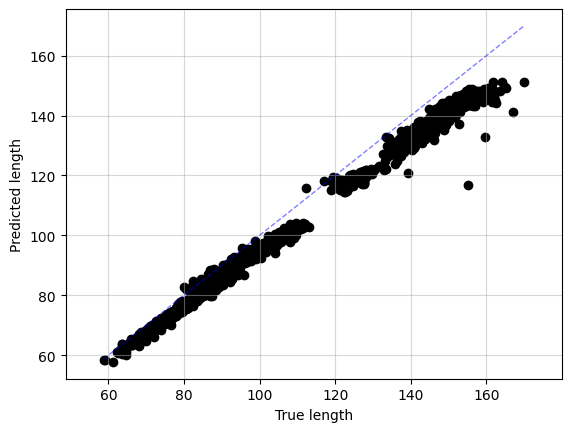

In [ ]:
## Validation
%matplotlib inline
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(true_lengths[0], predicted_lengths[0]))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(true_lengths[0], predicted_lengths[0]))

xmin = min(true_lengths[0])
xmax = max(true_lengths[0])
# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(true_lengths[0], predicted_lengths[0],  color='black')
ax.plot([xmin, xmax], [xmin, xmax],
        color='blue', linewidth=1, alpha=0.5, linestyle='--')
plt.xlabel('True length')
plt.ylabel('Predicted length')
plt.xlim([xmin - 10, xmax + 10])
plt.grid(True, alpha=0.5)
plt.title("")
plt.show()

## Prediction power is quite good

## Let's check if we can generate streamlines on demand, and check where they land

In [ ]:
generator = cond_VAE.encoder.get_layer("generator")

In [ ]:
lengths = 2* list(range(0, 300))
generated_tractogram = []
for length in lengths:
    r = tf.convert_to_tensor(np.array([[length]]))  # Gotta put it like this because of the batch dimension
    pz_mean, pz_log_var = generator(r)
    z = pz_mean + tf.exp(0.5 * pz_log_var) * tf.random.normal(pz_mean.shape)
    streamline = cond_VAE.decoder(z)
    generated_tractogram.append(streamline.numpy())

generated_tractogram = np.array(generated_tractogram).squeeze()

### Save the streamlines

In [ ]:
utils.save_tractogram(generated_tractogram,
                      os.path.join(output_dir,
                                  f"cond_vae_tractogram_good_0_300_range.trk"),
                      anat_fname)